In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from tensorflow.keras.applications.resnet50 import ResNet50


#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-13 12:08:01.747429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 12:08:04.005644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## ResNet50

In [5]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(250,250,3))

for layer in resnet50.layers:
    layer.trainable=False

resnet_model = Sequential()
resnet_model.add(resnet50)
resnet_model.add(BatchNormalization())
resnet_model.add(GlobalAveragePooling2D())
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(2048, activation='relu'))
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(6, activation='softmax'))
resnet_model.summary()

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-04-13 12:08:15.261803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:08:15.385055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:08:15.385577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                         

In [6]:
#compiling 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 27804550 (106.07 MB)
Trainable params: 421

In [7]:
import time
# Record the start time of training
start_time = time.time()

In [8]:
# Train the model
epochs = 10

#Training
resnet_history = resnet_model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10


2024-04-13 12:08:48.483773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-13 12:08:52.817264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-13 12:08:54.434421: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1edd13b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 12:08:54.435011: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-13 12:08:54.592141: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 12:08:55.249314: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

53/53 [==============================] - 64s 951ms/step - loss: 1.4480 - accuracy: 0.4012 - val_loss: 4.1415 - val_accuracy: 0.1667
Epoch 2/10
53/53 [==============================] - 49s 919ms/step - loss: 1.2144 - accuracy: 0.5250 - val_loss: 2.5021 - val_accuracy: 0.2690
Epoch 3/10
53/53 [==============================] - 49s 927ms/step - loss: 1.0719 - accuracy: 0.5929 - val_loss: 1.9962 - val_accuracy: 0.2857
Epoch 4/10
53/53 [==============================] - 50s 935ms/step - loss: 1.0314 - accuracy: 0.6089 - val_loss: 1.7253 - val_accuracy: 0.3048
Epoch 5/10
53/53 [==============================] - 49s 930ms/step - loss: 1.0139 - accuracy: 0.6113 - val_loss: 1.4467 - val_accuracy: 0.4214
Epoch 6/10
53/53 [==============================] - 48s 913ms/step - loss: 0.9576 - accuracy: 0.6417 - val_loss: 1.1729 - val_accuracy: 0.5714
Epoch 7/10
53/53 [==============================] - 50s 940ms/step - loss: 0.9410 - accuracy: 0.6375 - val_loss: 1.1923 - val_accuracy: 0.5476
Epoch 8/10

In [9]:
# Record the training end time
end_time = time.time()

In [10]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 601.2555387020111 seconds


In [11]:
pd.DataFrame(resnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.448034,0.401190,4.141506,0.166667
1,1.214370,0.525000,2.502092,0.269048
2,1.071921,0.592857,1.996238,0.285714
3,1.031353,0.608929,1.725295,0.304762
4,1.013932,0.611310,1.446694,0.421429
5,0.957577,0.641667,1.172880,0.571429
6,0.940962,0.637500,1.192312,0.547619
7,0.886166,0.652381,1.154678,0.578571
8,0.870751,0.667262,1.028608,0.619048
9,0.843730,0.683333,0.989927,0.607143


In [12]:
import joblib

joblib.dump(resnet_history.history,'history_ResNet50_DA.pkl')
resnet_history = joblib.load('history_ResNet50_DA.pkl')

In [13]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

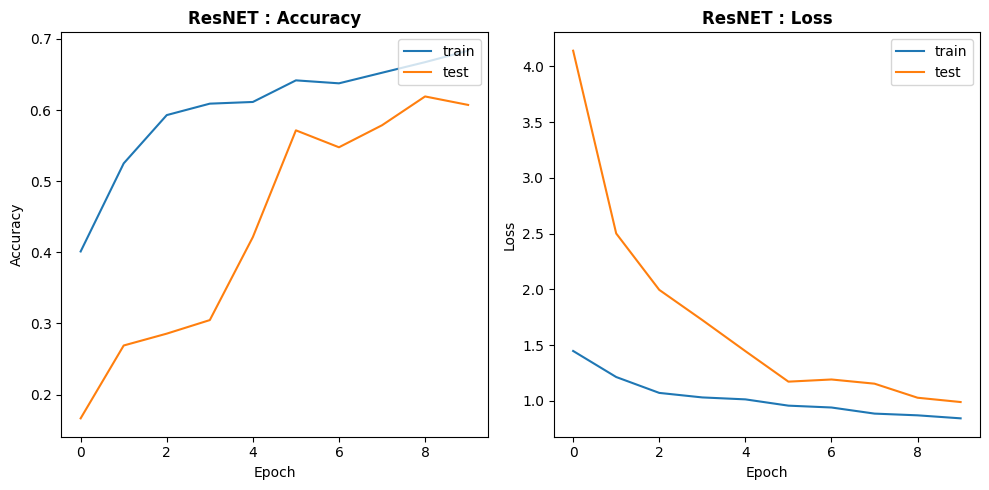

In [16]:
plot_performance(model_name='ResNET',
                acc=resnet_history['accuracy'], 
                 val_acc=resnet_history['val_accuracy'],
                 loss=resnet_history['loss'], 
                 val_loss=resnet_history['val_loss'])

In [17]:
resnet_model.save('resnet_model_DA.h5')